In [1]:
import pandas as pd

PATH = "winemag-data_first150k.csv"

def load_wine_data(wine_path=PATH):
    return pd.read_csv(wine_path)

In [2]:
wineReviews = load_wine_data()
wineReviews.info()
wineReviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   150930 non-null  int64  
 1   country      150925 non-null  object 
 2   description  150930 non-null  object 
 3   designation  105195 non-null  object 
 4   points       150930 non-null  int64  
 5   price        137235 non-null  float64
 6   province     150925 non-null  object 
 7   region_1     125870 non-null  object 
 8   region_2     60953 non-null   object 
 9   variety      150930 non-null  object 
 10  winery       150930 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023B44EE54C8>,
      dtype=object)

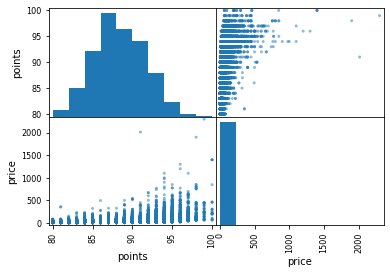

In [3]:
from pandas.plotting import scatter_matrix

attributes = ["points", "price"]
scatter_matrix(wineReviews[attributes])

In [4]:
corr_matrix = wineReviews.corr()
corr_matrix["points"].sort_values(ascending=True)

Unnamed: 0   -0.094197
price         0.459863
points        1.000000
Name: points, dtype: float64

In [5]:
fill = "nowhere"
wineReviews["province"].fillna(fill, inplace=True)
wineReviews["region_1"].fillna(fill, inplace=True)

wineReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   150930 non-null  int64  
 1   country      150925 non-null  object 
 2   description  150930 non-null  object 
 3   designation  105195 non-null  object 
 4   points       150930 non-null  int64  
 5   price        137235 non-null  float64
 6   province     150930 non-null  object 
 7   region_1     150930 non-null  object 
 8   region_2     60953 non-null   object 
 9   variety      150930 non-null  object 
 10  winery       150930 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


In [6]:
from sklearn.preprocessing import OrdinalEncoder

cat_encoder = OrdinalEncoder()

wine_province = wineReviews[["province"]]
wine_region1 = wineReviews[["region_1"]]
wine_variety = wineReviews[["variety"]]


wine_province_ord = cat_encoder.fit_transform(wine_province)
wine_region1_ord = cat_encoder.fit_transform(wine_region1)
wine_variety_ord = cat_encoder.fit_transform(wine_variety)

wineReviews["province"] = wine_province_ord
wineReviews["region_1"] = wine_region1_ord
wineReviews["variety"] = wine_variety_ord
wineReviews.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   150930 non-null  int64  
 1   country      150925 non-null  object 
 2   description  150930 non-null  object 
 3   designation  105195 non-null  object 
 4   points       150930 non-null  int64  
 5   price        137235 non-null  float64
 6   province     150930 non-null  float64
 7   region_1     150930 non-null  float64
 8   region_2     60953 non-null   object 
 9   variety      150930 non-null  float64
 10  winery       150930 non-null  object 
dtypes: float64(4), int64(2), object(5)
memory usage: 12.7+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023B4BB85208>,
      dtype=object)

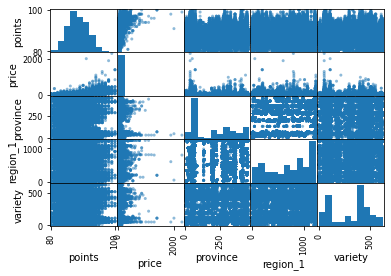

In [7]:
from pandas.plotting import scatter_matrix

attributes = ["points", "price", "province", "region_1", "variety"]
scatter_matrix(wineReviews[attributes])

['Cabernet Sauvignon' 'Sauvignon Blanc' 'Pinot Noir' 'Chardonnay' 'Syrah'
 'Red Blend' 'Riesling' 'Bordeaux-style Red Blend' 'Merlot']
['Chardonnay', 'Pinot Noir', 'Cabernet Sauvignon', 'Red Blend', 'Bordeaux-style Red Blend', 'Sauvignon Blanc', 'Syrah', 'Riesling', 'Merlot']


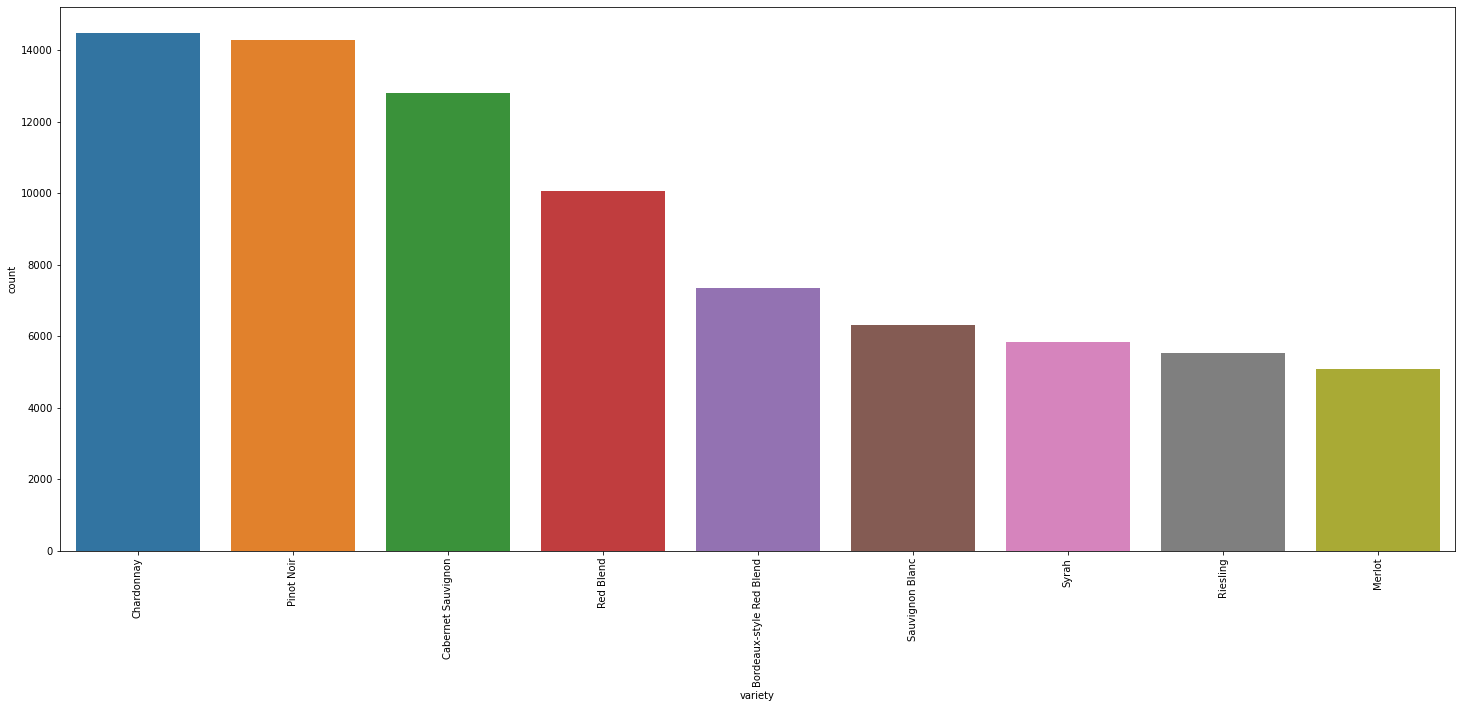

'\nfig = plt.figure()\nax = fig.add_axes([0,0,1,1])\nax.bar(variety_common, varieties)\nplt.show()\n'

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

wineReviews = load_wine_data() #reset it back to normal

#get the wine varieties with more than 4000 reviews
variety_common = wineReviews.groupby("variety").filter(lambda x: len(x) > 4000)
varieties = variety_common["variety"].value_counts().index.tolist()

print(variety_common['variety'].unique())
print(varieties)

fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = variety_common['variety'], order = varieties, ax = ax)
plt.xticks(rotation = 90)
plt.show()

'''
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(variety_common, varieties)
plt.show()
'''

In [40]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

wineReviews = wineReviews.drop_duplicates('description')
#may want to get rid of variety names, years, and punctuations
punc = ['.', '. .', '. . .', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%", '$', '+', '/', '1', '2', 
        '3','4','5','6','7','8','9', 'flavor'] 
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
desc = variety_common['description'].values
vectorizer = TfidfVectorizer(stop_words = stop_words)
X = vectorizer.fit_transform(desc)

word_features = vectorizer.get_feature_names()
word_features[500:525]

['abrupt',
 'abruptly',
 'abruzzo',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absorb',
 'absorbed',
 'absorbs',
 'abstberg',
 'abtsberg',
 'abundance',
 'abundant',
 'abundantly',
 'abused',
 'abv',
 'abyss',
 'acacia',
 'academic',
 'acate',
 'acccessible',
 'accelerates',
 'accelerator',
 'accent']

In [41]:
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
tokenizer = TweetTokenizer()

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

In [42]:
vectorizer2 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 500)
X2 = vectorizer2.fit_transform(desc)
word_features2 = vectorizer2.get_feature_names()
word_features2[:50]

C:\Users\Mathias\anaconda3\envs\HOML\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


['-',
 '10',
 '100',
 '20',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2015',
 '2016',
 '2017',
 '2018',
 '2020',
 'accent',
 'acid',
 'ad',
 'add',
 'addit',
 'aftertast',
 'age',
 'alcohol',
 'almond',
 'alongsid',
 'alreadi',
 'alway',
 'ampl',
 'ani',
 'anis',
 'anoth',
 'appeal',
 'appel',
 'appl',
 'approach',
 'apricot',
 'aroma',
 'aromat',
 'asian',
 'astring',
 'attract',
 'auster',
 'bacon',
 'bake',
 'balanc',
 'barrel',
 'basic',
 'beauti',
 'becaus']

In [43]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 15, n_init = 5, n_jobs = -1)
kmeans.fit(X2)

C:\Users\Mathias\anaconda3\envs\HOML\lib\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


KMeans(n_clusters=15, n_init=5, n_jobs=-1)

In [44]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(word_features2[word] for word in centroid))

0 : appl, finish, peach, palat, lime, lemon, riesl, note, acid, pear
1 : berri, aroma, palat, finish, plum, herbal, nose, red, note, feel
2 : sweet, cherri, tast, soft, simpl, like, candi, raspberri, wine, blackberri
3 : citrus, appl, finish, fruit, wine, acid, crisp, miner, aroma, palat
4 : pinot, noir, cherri, cola, silki, raspberri, dri, acid, drink, wine
5 : black, cherri, fruit, aroma, pepper, palat, tannin, plum, wine, finish
6 : blackberri, dri, currant, tannin, cherri, drink, rich, wine, oak, soft
7 : year, cellar, tannin, blackberri, wine, currant, cherri, –, develop, oak
8 : fresh, wine, acid, fruit, light, soft, fruiti, crisp, attract, drink
9 : pineappl, chardonnay, butter, toast, oak, vanilla, acid, pear, rich, peach
10 : wine, fruit, age, wood, structur, tannin, rich, ripe, year, firm
11 : fruit, wine, finish, cherri, tannin, red, light, oak, vineyard, note
12 : cabernet, blend, sauvignon, merlot, franc, petit, verdot, wine, syrah, fruit
13 : blanc, sauvignon, crisp, grap

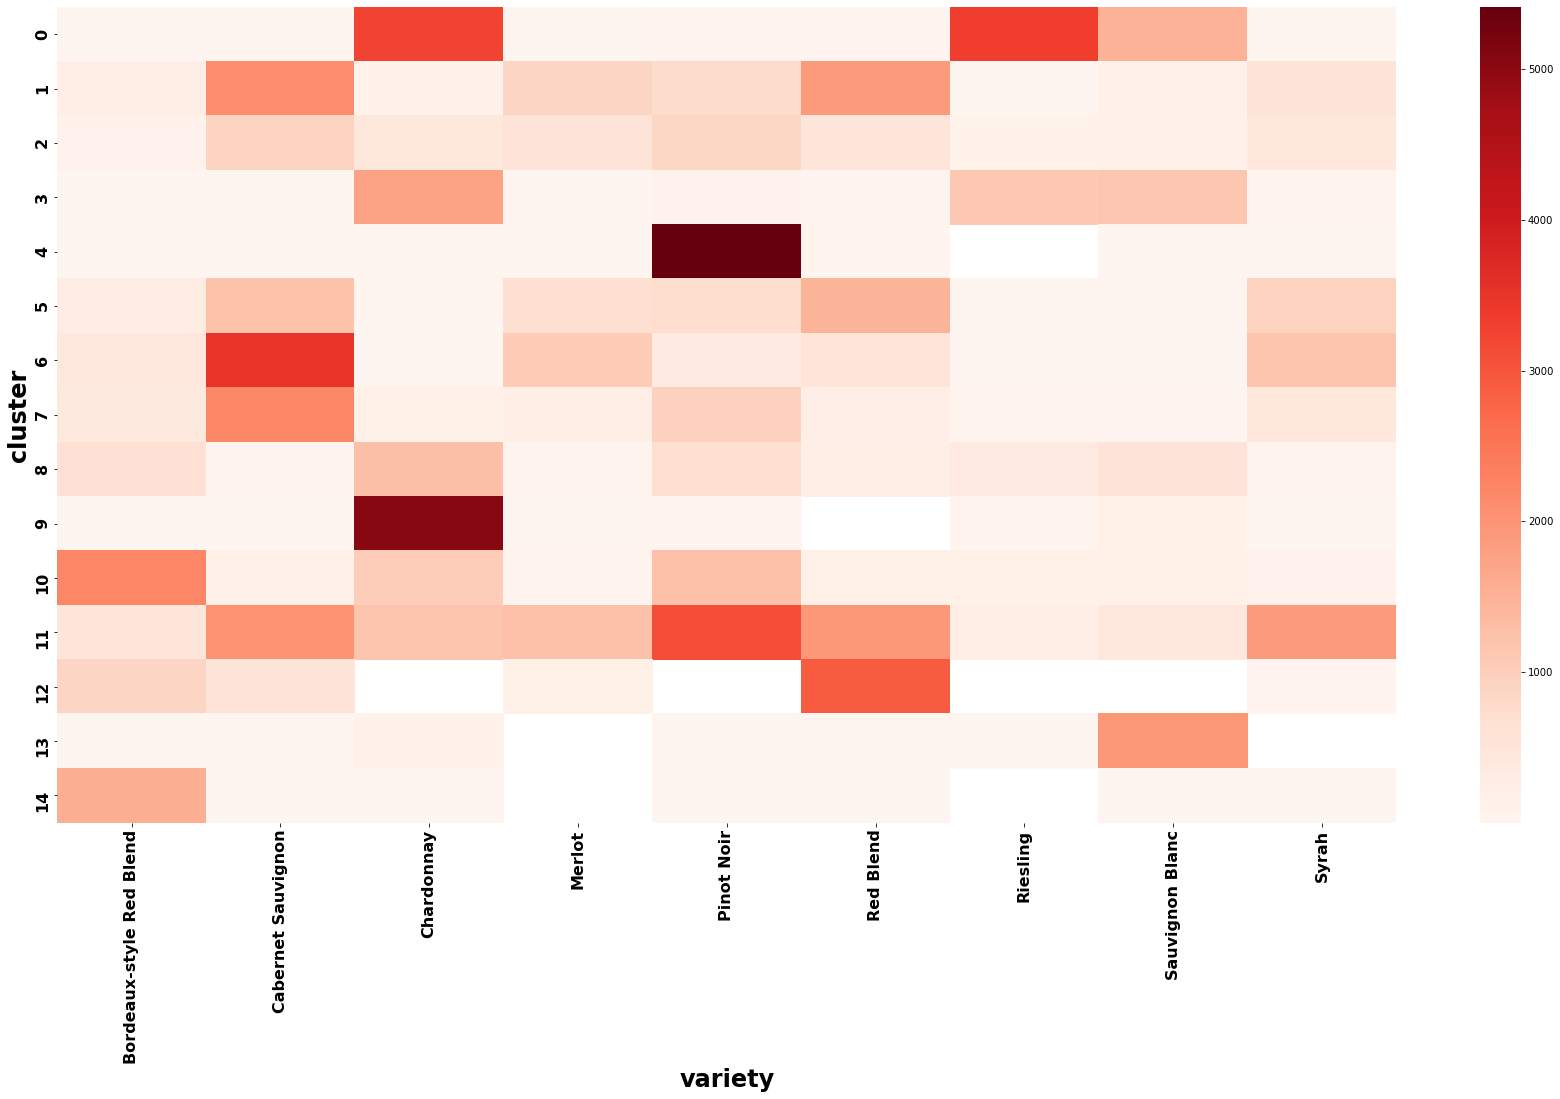

In [45]:
variety_common['cluster'] = kmeans.labels_
clusters = variety_common.groupby(['cluster', 'variety']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'variety'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('variety', fontdict = {'weight': 'bold', 'size': 24})
plt.xticks(rotation = 90)
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")